In [1]:
# Making some essential imports as Usual
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Replace 'your_folder_path' with the actual path to your image folder
folder_path = '/content/drive/MyDrive/T5_Python/building_classification/train'


'''
# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith("_mask.png"):
        file_path = os.path.join(folder_path, filename)

        # Load the image
        image = cv2.imread(file_path)

        # Check if the image was loaded successfully
        if image is not None:
            # Display the loaded image

            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title("Original Image")
            plt.axis('off')

            # Check if any pixel is equal to (0, 255, 255) and set it to white (255, 255, 255)
            mask = (image == [255,255,0]).all(axis=-1)

            # Set pixels with value (0, 255, 255) to white (255, 255, 255) and the rest to black (0, 0, 0)
            image[mask] = [255, 255, 255]
            image[~mask] = [0, 0, 0]

            cv2.imwrite(file_path, image)

            # Display the altered image

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title("Altered Image")
            plt.axis('off')

            plt.show()

            #print(f"Processed: {filename}")

        else:
            print(f"Failed to load image: {filename}")

print("Processing complete.")
'''

'\n# Loop through all files in the folder\nfor filename in os.listdir(folder_path):\n    if filename.endswith("_mask.png"):\n        file_path = os.path.join(folder_path, filename)\n\n        # Load the image\n        image = cv2.imread(file_path)\n\n        # Check if the image was loaded successfully\n        if image is not None:\n            # Display the loaded image\n            \n            plt.figure(figsize=(8, 4))\n            plt.subplot(1, 2, 1)\n            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))\n            plt.title("Original Image")\n            plt.axis(\'off\')\n            \n            # Check if any pixel is equal to (0, 255, 255) and set it to white (255, 255, 255)\n            mask = (image == [255,255,0]).all(axis=-1)\n\n            # Set pixels with value (0, 255, 255) to white (255, 255, 255) and the rest to black (0, 0, 0)\n            image[mask] = [255, 255, 255]\n            image[~mask] = [0, 0, 0]\n\n            cv2.imwrite(file_path, image)

In [ ]:

import os
import cv2
folder_path = '/content/drive/MyDrive/T5_Python/building_classification/train'
def remove_images_with_zero_sum(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith("_mask.png"):  # You can adjust the file extension as needed
            file_path = os.path.join(folder_path, filename)

            # Load the image
            image = cv2.imread(file_path)

            # Check if the image was loaded successfully
            if image is not None:
                # Calculate the sum of pixel values
                pixel_sum = image.sum()

                # Check if the pixel sum is zero
                if pixel_sum == 0:
                    # Remove the image file
                    os.remove(file_path)
                    print(f"Removed: {filename}")
                else:
                    print(f"Image '{filename}' has a pixel sum of {pixel_sum}. It will not be removed.")
            else:
                print(f"Failed to load image: {filename}")

    print("Processing complete.")

# Call the function with the folder path
  # Replace with your actual folder path
remove_images_with_zero_sum(folder_path)


Image '438721_mask.png' has a pixel sum of 127690740. It will not be removed.
Image '43814_mask.png' has a pixel sum of 675241785. It will not be removed.
Image '442329_mask.png' has a pixel sum of 2739515490. It will not be removed.
Image '437963_mask.png' has a pixel sum of 3737285865. It will not be removed.
Image '434210_mask.png' has a pixel sum of 327408525. It will not be removed.
Image '435277_mask.png' has a pixel sum of 2124121950. It will not be removed.
Image '457265_mask.png' has a pixel sum of 111589020. It will not be removed.
Image '44070_mask.png' has a pixel sum of 7937640. It will not be removed.
Image '45357_mask.png' has a pixel sum of 5595975. It will not be removed.
Image '444902_mask.png' has a pixel sum of 96624855. It will not be removed.
Image '457070_mask.png' has a pixel sum of 1601760060. It will not be removed.
Image '442338_mask.png' has a pixel sum of 3141640035. It will not be removed.
Image '455374_mask.png' has a pixel sum of 2984208390. It will not 

In [3]:
# defining function for dataLoading function
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []

    ## generating mask names
    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem)

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg')
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')

        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0

    return frameObj

In [9]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x



# Now defining Unet
def Unet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path

    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)
    p5 = tf.keras.layers.Dropout(droupouts)(p5)

    c6 = Conv2dBlock(p5, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    # defining decoder path
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*16, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c5])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c4])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c3])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u10 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c9)
    u10 = tf.keras.layers.concatenate([u10, c2])
    u10 = tf.keras.layers.Dropout(droupouts)(u10)
    c10 = Conv2dBlock(u10, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u11 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c10)
    u11 = tf.keras.layers.concatenate([u11, c1])
    u11 = tf.keras.layers.Dropout(droupouts)(u11)
    c11 = Conv2dBlock(u11, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c11)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model


In [10]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
unet = Unet(inputs, droupouts= 0.03)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

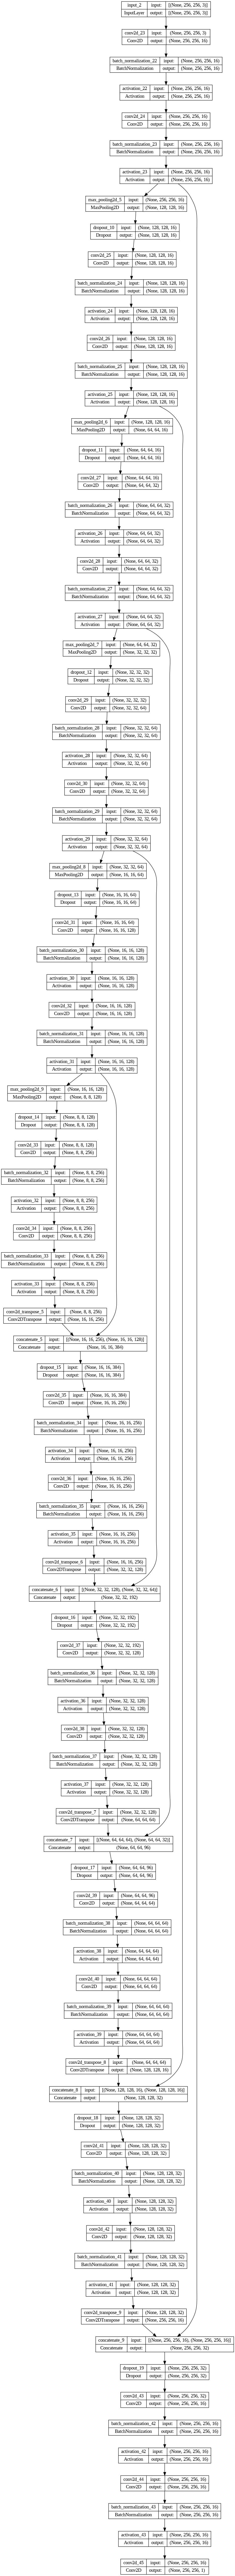

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(unet, to_file='UnetArchitecture.png', show_shapes=True, show_layer_names=True)

In [12]:
framObjTrain = LoadData(
    framObjTrain, imgPath = '/content/drive/MyDrive/T5_Python/building_classification/train',
    maskPath = '/content/drive/MyDrive/T5_Python/building_classification/train'
    , shape = 256)

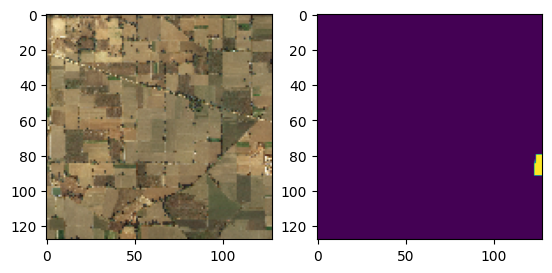

In [ ]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][0])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][0])
plt.show()

In [13]:
retVal = unet.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 50, verbose = 1)

Epoch 1/50
41/41 [==============================] - 24s 183ms/step - loss: 0.3499 - accuracy: 0.8887
Epoch 2/50
41/41 [==============================] - 6s 144ms/step - loss: 0.2045 - accuracy: 0.9385
Epoch 3/50
41/41 [==============================] - 6s 147ms/step - loss: 0.1761 - accuracy: 0.9406
Epoch 4/50
41/41 [==============================] - 6s 144ms/step - loss: 0.1626 - accuracy: 0.9422
Epoch 5/50
41/41 [==============================] - 6s 146ms/step - loss: 0.1471 - accuracy: 0.9462
Epoch 6/50
41/41 [==============================] - 6s 144ms/step - loss: 0.1394 - accuracy: 0.9482
Epoch 7/50
41/41 [==============================] - 6s 146ms/step - loss: 0.1373 - accuracy: 0.9470
Epoch 8/50
41/41 [==============================] - 6s 145ms/step - loss: 0.1352 - accuracy: 0.9473
Epoch 9/50
41/41 [==============================] - 6s 144ms/step - loss: 0.1224 - accuracy: 0.9523
Epoch 10/50
41/41 [==============================] - 6s 147ms/step - loss: 0.1243 - accuracy: 0.950

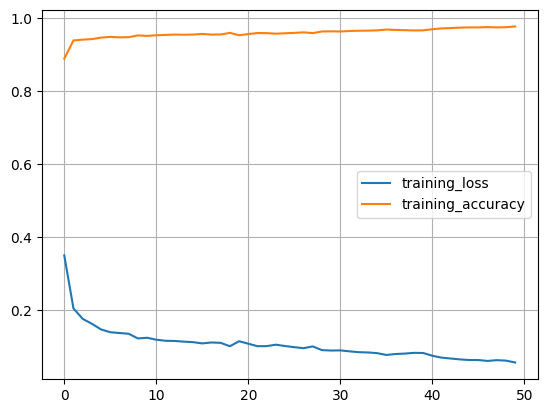

In [14]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [15]:
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img'][0:649]
    mask = valMap['mask'][0:649]
    #mask = mask[0:16]

    imgProc = img[0:649]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)


    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(12,12))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Aerial image')

    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Routes')

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual Routes')



In [16]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, unet)

21/21 [==============================] - 1s 44ms/step


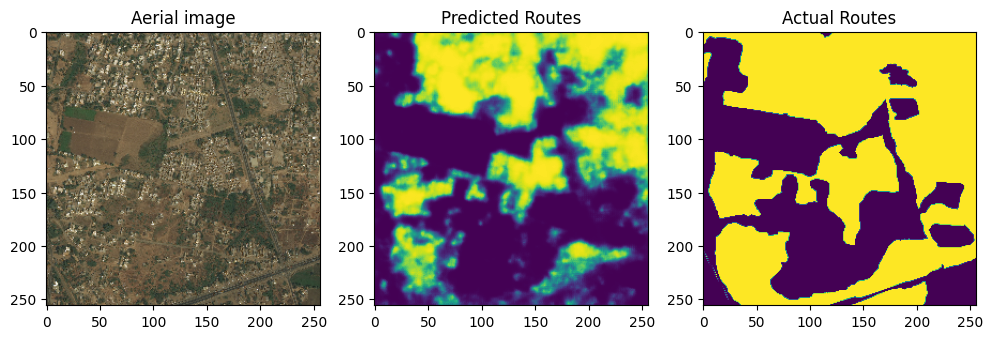

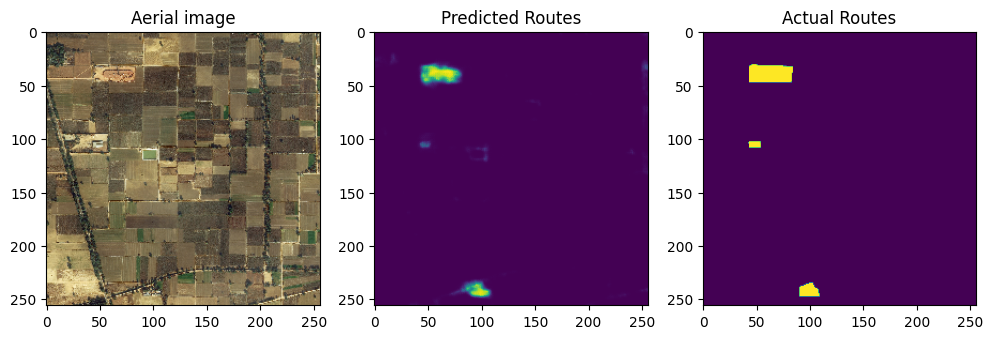

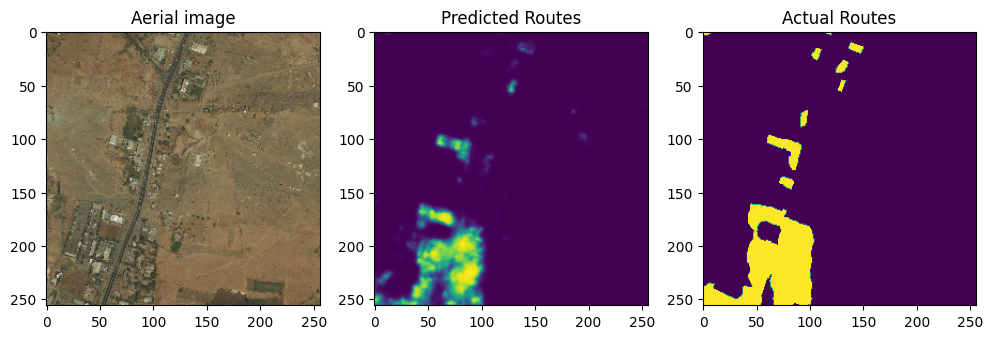

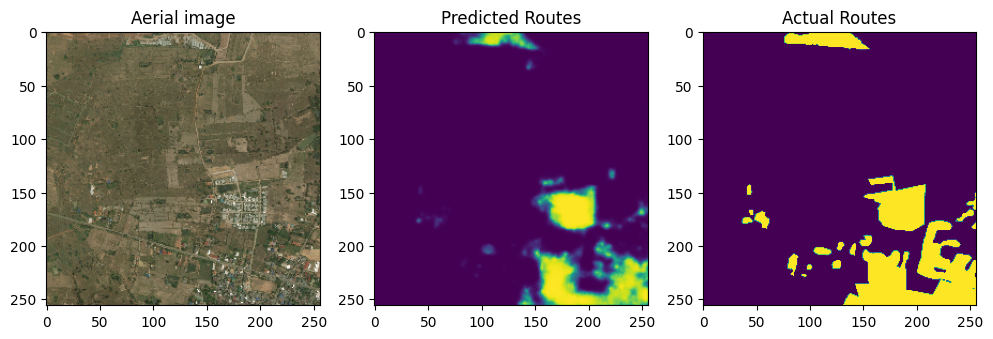

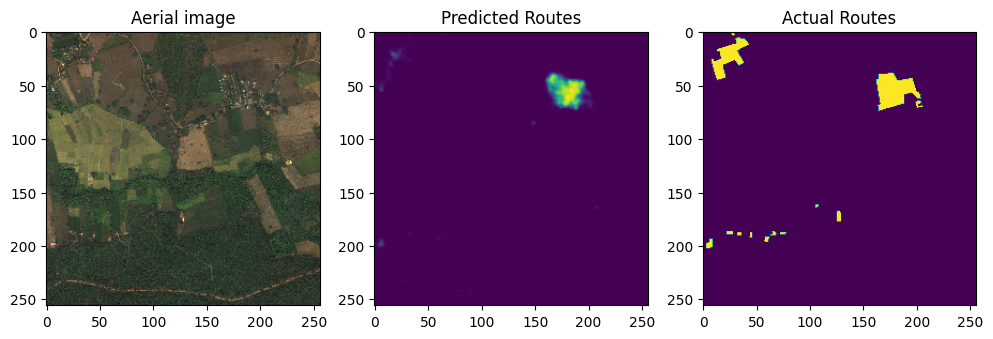

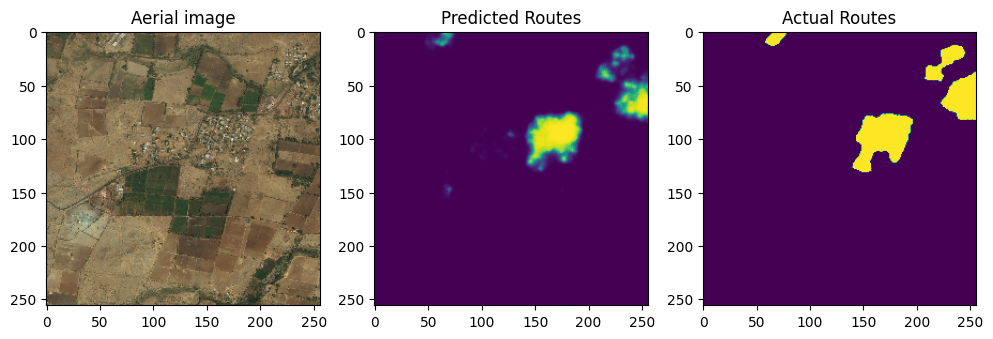

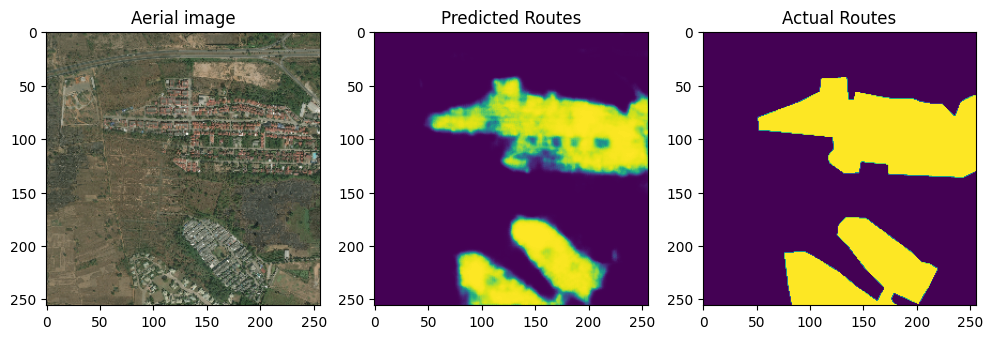

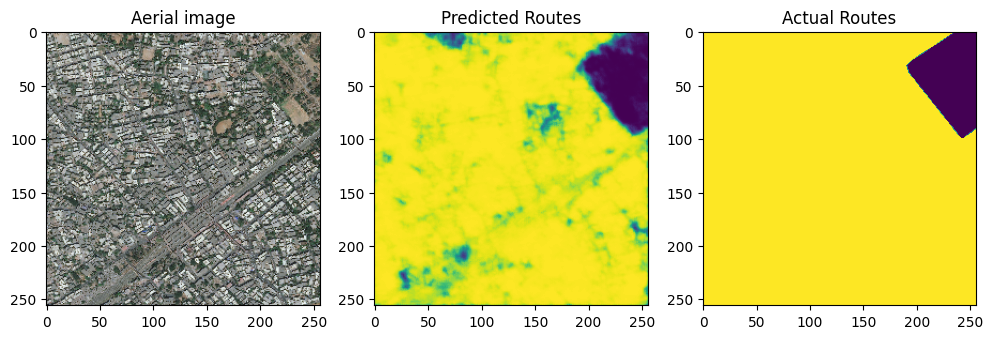

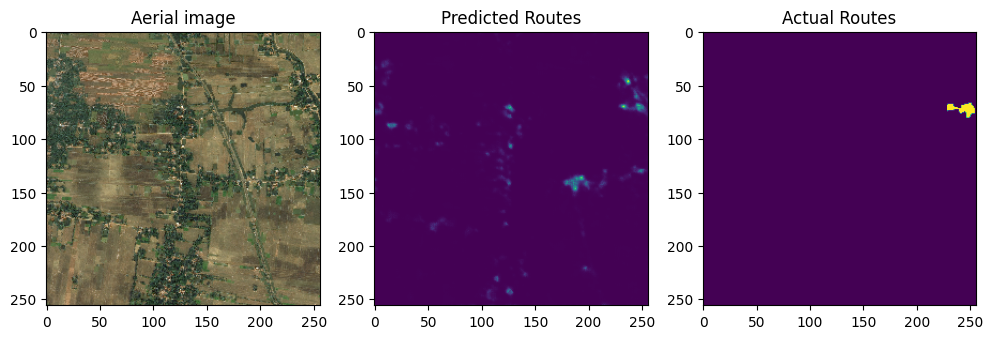

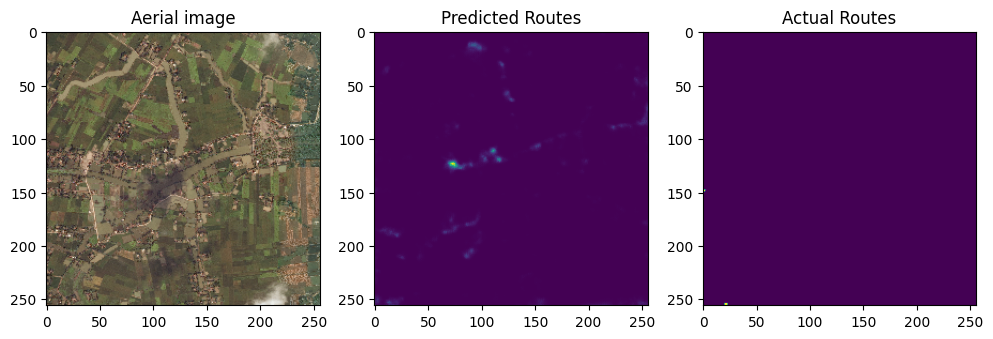

In [17]:
import random

# Generate 10 random numbers between 1 and 9000
random_numbers = [random.randint(1, 649) for _ in range(10)]

for i in random_numbers:
  Plotter(actuals[i], sixteenPrediction[i][:,:,0], masks[i])

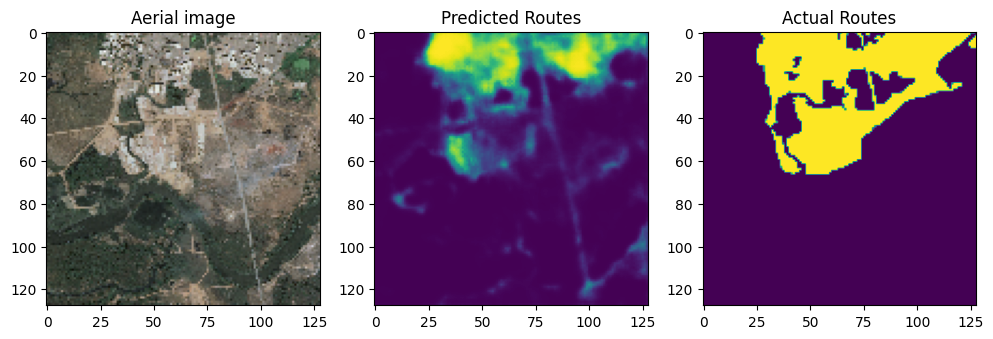

In [ ]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

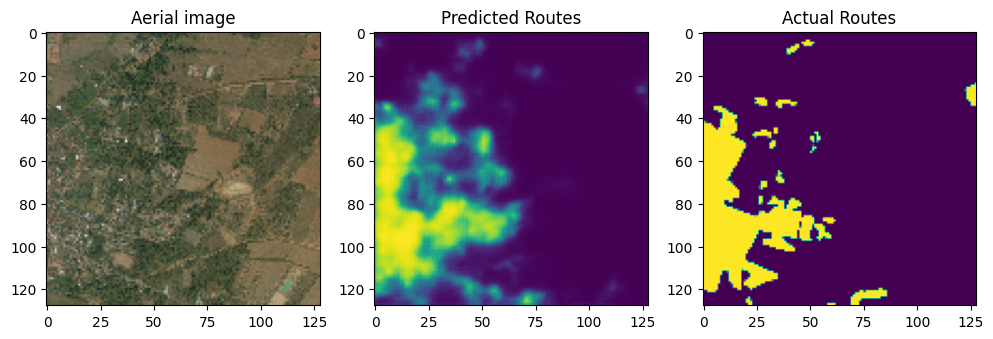

In [ ]:
Plotter(actuals[3], sixteenPrediction[3][:,:,0], masks[3])

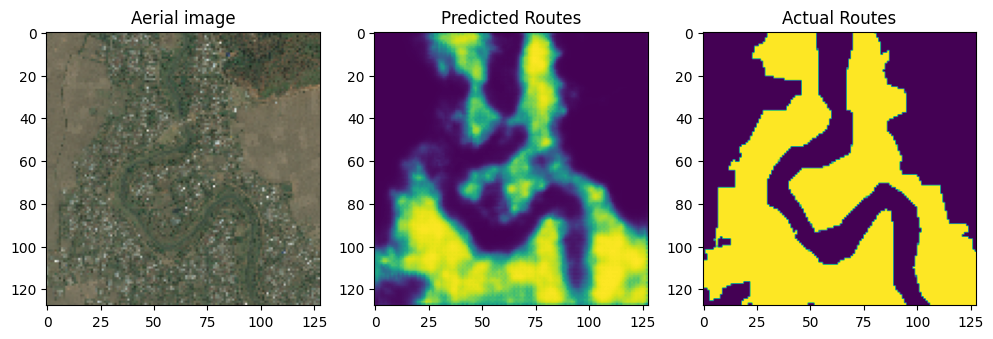

In [ ]:
Plotter(actuals[5], sixteenPrediction[5][:,:,0], masks[5])

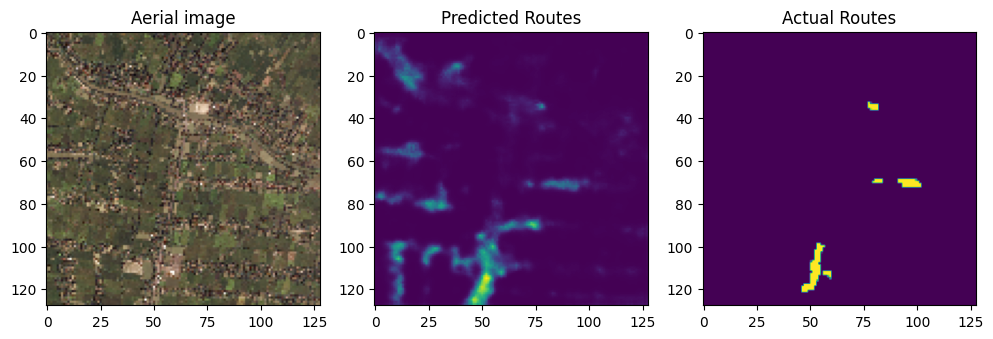

In [ ]:
Plotter(actuals[27], sixteenPrediction[27][:,:,0], masks[27])

In [ ]:
unet.save('RouteGenerator.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
